In [44]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib.colors import TwoSlopeNorm
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

In [2]:
from pyspark.sql import functions as F, SparkSession

spark = (
    SparkSession.builder.appName("Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/06 11:35:19 WARN Utils: Your hostname, dash_surface resolves to a loopback address: 127.0.1.1; using 172.24.202.44 instead (on interface eth0)
22/10/06 11:35:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/06 11:35:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Preprocessing

## External preprocessing



**Background\External data**<br>
2 factors that can be used to predict BNPL usage are age and gender. Although income is also a valid factor, using income and age violates the assumption of independence of predictor variables, as age and income are strongly corrrelated, particularly among young people. BNPL usage by age is diplayed in the figure below. **57% of BNPL users are Female**. <br><br>
Using bayes rule we were able to construct a series of conditional probabilities that an individual uses BNPL given their age and gender.<br>
**Assumptions**
- 25% of people in Australia use BNPL
- Each age range has the same gender distribution of BNPL users




**Consumer data**<br>
The 2 features of interest in the consumer dataset are Gender and Postcode.

**Postcodes**<br>
2 types of geographical data were used in the analysis
- Postcode: Managed by Australia Post
- ABS Postal Areas: Managed by the ABS

First postcode data was mapped to ABS Postal Areas. ABS Postal Areas are an estimation of postcodes (which are managed by Australia post) and thus do not cover all postcodes in Australia. They are also not 100% accurate as some postcodes are split accross multiple ABS Postal Areas (More information available here: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/non-abs-structures/postal-areas). Postcodes present in the consumer dataset and not in the ABS dataset were mapped to ABS Postal Areas using an opensource data set for Australian postcode geographies (available here: https://www.matthewproctor.com/australian_postcodes). All but 2 postcodes could be mapped to ABS Postal Areas, however it should be noted that these are estimates and not all postcodes correspond to a physical address of a customer. Examples include "post office boxes, mail back competitions, large volume receivers and specialist delivery postcodes" (ABS, non-abs-structures)
<br><br>

Using the Gender and ABS Postal Area for each customer and combining this with population data by age and gender from the 2021 census, we were able to construct an age probability distribution for each customer in the data set.<br>

**Assumptions**
- All customers are above the age of 18
- Customers of all ages (above 18) are equally likely to appear in the transaction data set.

By combining this with the previously computed conditional probabilities we are able to estimate the probability that a given customer uses BNPL given their ABS Postal Area and Gender. In the following section, there are graphs visualising our assumptions for the data

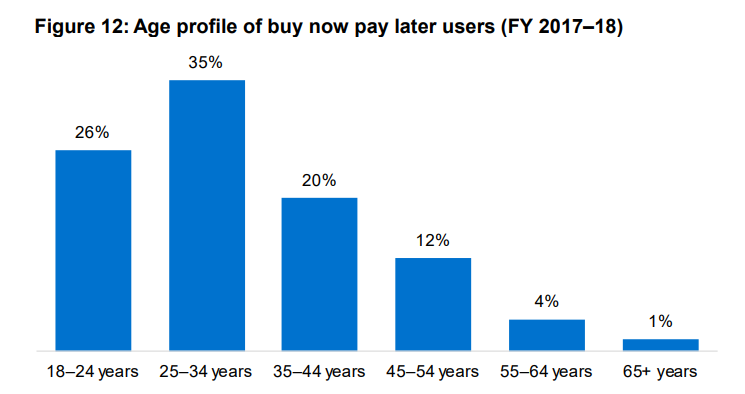

In [43]:
Image('../plots/bnpl_use_by_age.PNG')

In [84]:
poa_gdf = gpd.read_file('../data/raw/postcodes/abs_postal_areas.zip')

weights_df = pd.read_parquet('../data/curated/demographic_weights.parquet')
postcodes_gdf = gpd.read_file('../data/raw/postcodes/postcodes.csv')
poa_gdf = pd.merge(poa_gdf[['POA_CODE21', 'geometry']], postcodes_gdf[['postcode', 'state']].drop_duplicates(), left_on = 'POA_CODE21', right_on = 'postcode', how = 'left')
age_proportions_df = pd.read_parquet('../data/curated/census/age_proportions.parquet')

weights_df = pd.merge(weights_df, age_proportions_df[age_proportions_df['gender'] == 'Person'].drop('gender',axis = 1), on = 'poa')
poa_gdf = poa_gdf[~poa_gdf['geometry'].isnull()]
weights_gdf = pd.merge(poa_gdf, weights_df[weights_df['gender'] == 'Undisclosed'], left_on = 'POA_CODE21', right_on = 'poa').drop('POA_CODE21', axis = 1)

In [66]:
def make_chloropleth_map(gdf, var):
    cmap = 'YlOrRd'
    norm = TwoSlopeNorm(
        vmin = 0,
        vcenter = gdf[var].median(),
        vmax = gdf[var].nlargest(5).iloc[-1]
    )

    cbar = plt.cm.ScalarMappable(
        norm = norm,
        cmap = cmap
    )

    fig, ax = plt.subplots(1,1, figsize = (16,9))
    gdf.plot(column = var, cmap = cmap, norm = norm, ax = ax)
    fig.colorbar(cbar, ax=ax)
    ax.set_axis_off()

In general young people tend to live in urban areas, were as the elderly population tend to live in rural areas. This can be seen in the chloropleth maps below. As a result of this urban areas tend to recieve a higher probability of BNPL use

Map of proportion of 18_24 year olds for postcodes in victoria. <Br><br>


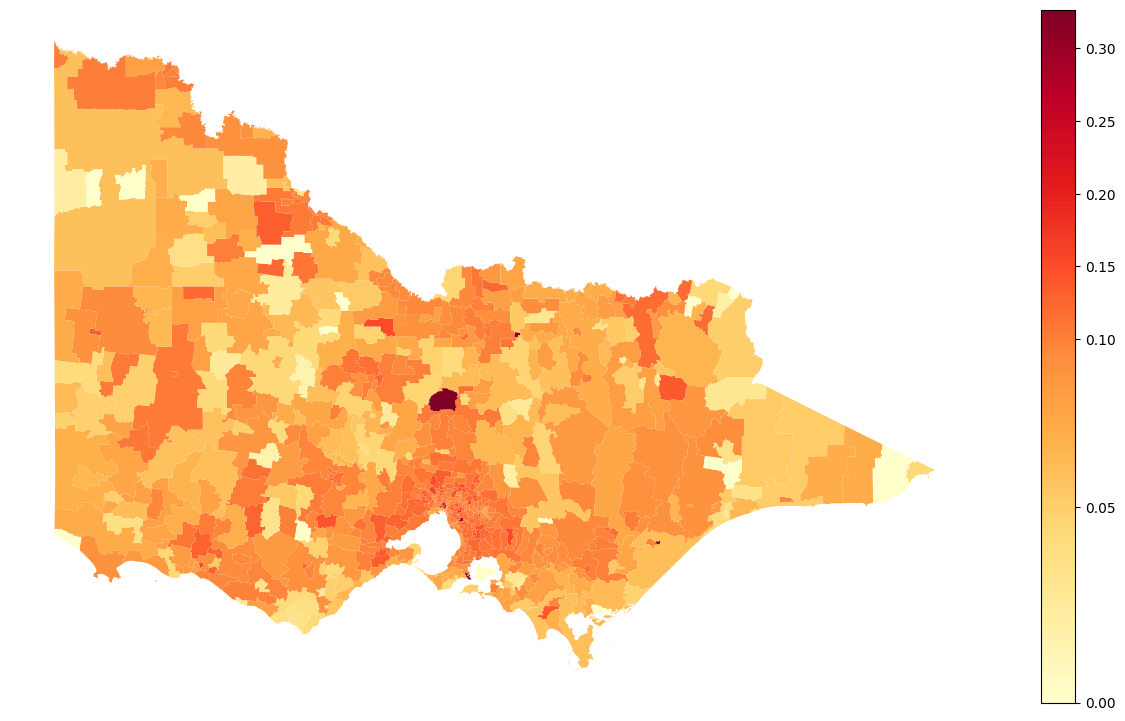

In [86]:
make_chloropleth_map(weights_gdf[weights_gdf['state'] == 'VIC'], 'age_18_24')

map of proportion of 65+ year olds for postcodes in victoria

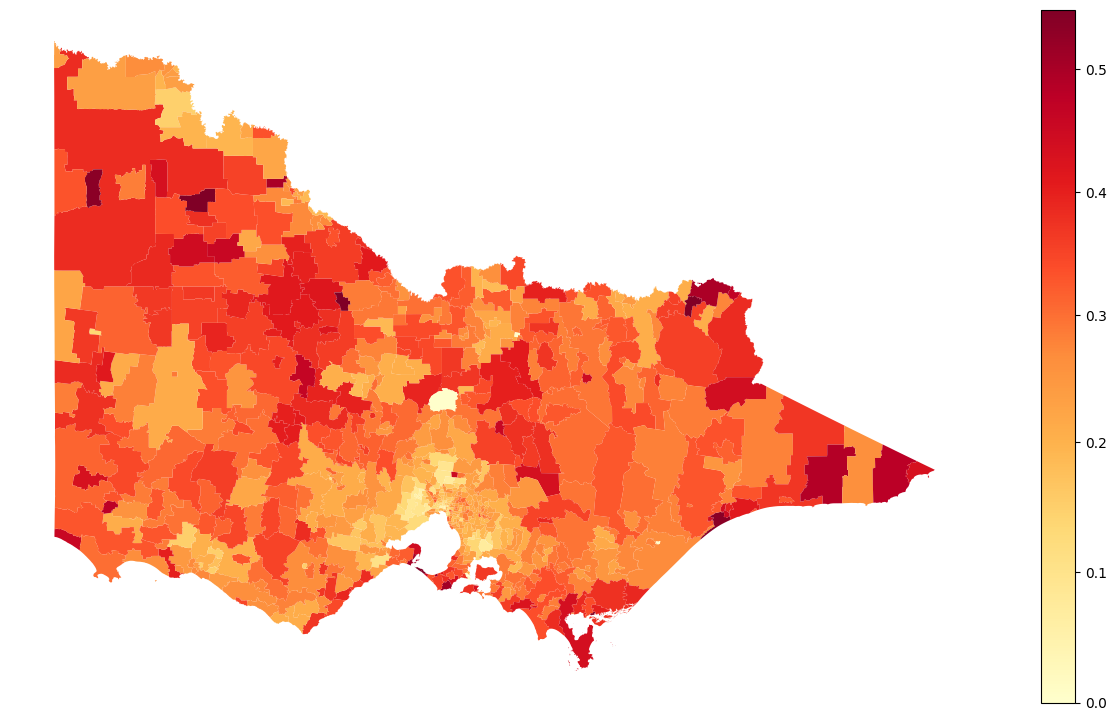

In [87]:
make_chloropleth_map(weights_gdf[weights_gdf['state'] == 'VIC'], 'age_65+')

Map of weights for each postcode (for gender unknown)

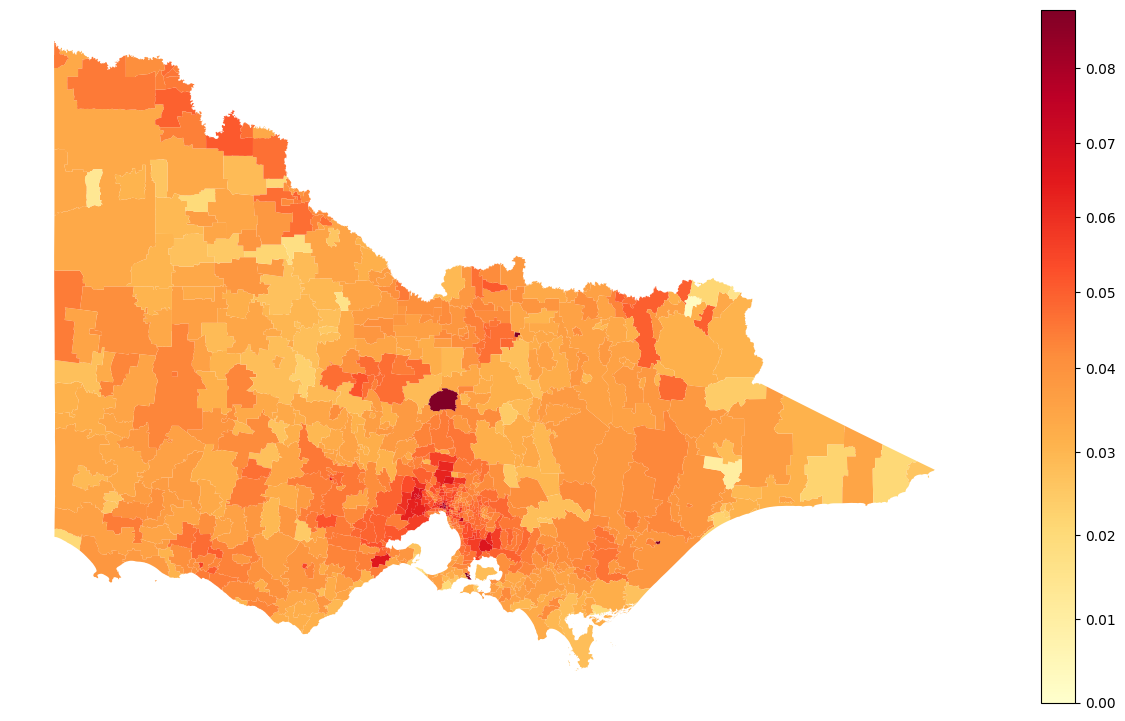

In [88]:
make_chloropleth_map(weights_gdf[weights_gdf['state'] == 'VIC'], 'weight')

Weight v proportion of adult population between 18 and 24 by gender for every postal area in Australia

In [98]:
px.scatter(
    pd.pivot_table(
        weights_df,
        index = ['poa', 'gender'],
    ).reset_index().query(
        'gender.isin(["Male", "Female"])'
    ),
    x = 'age_18_24',
    y = 'weight',
    color = 'gender'
)

Distribution of weights by gender

In [110]:
fig = px.histogram(weights_df.query('gender.isin(["Male", "Female"])'), x = 'weight', color = 'gender')
fig.update_layout(barmode = 'overlay')
fig.update_traces(opacity=0.75)

## Consumer preprocessing

Consumer postcodes that did not match up with the consumer's state were set to 'null'. This way, we could perform mean imputation while creating the model. 

Further, the distribution for gender and postcodes were observed to determine if there is inherent bias within the data.

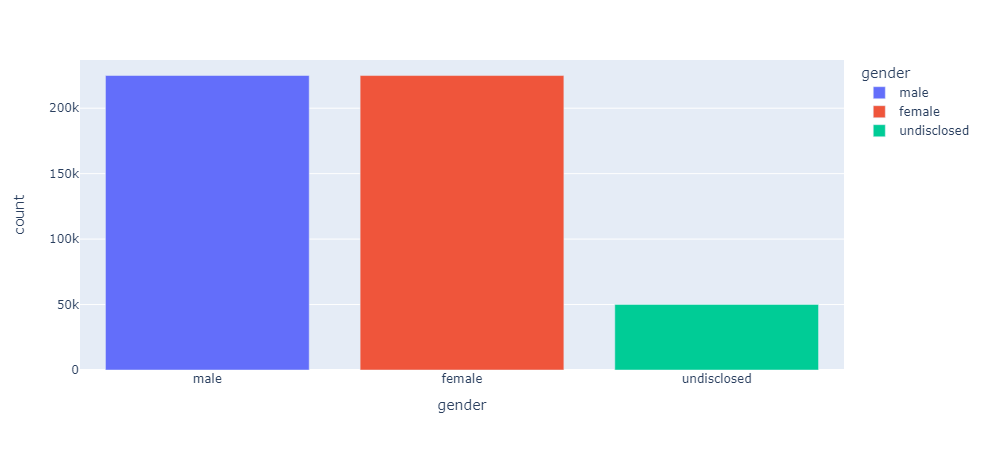

In [2]:
Image('../plots/gender_counts.png')

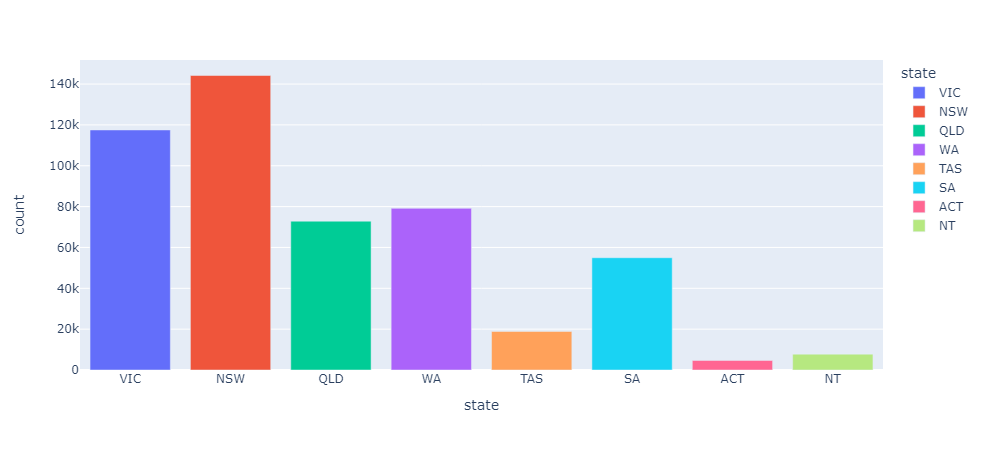

In [3]:
Image('../plots/state_counts.png')

## Merchant preprocessing

For each data entry of the merchants, the label was extracted and split into the necessary parts. This resulted in a final number of 25 unique tags across all merchants which then was segmented into 5 groups accroding to the merchant's wares. 

The segments are as follows:
- Home
- Art
- Accessories
- Media and Technology
- Miscellaneous

In [3]:
segments_df = pd.read_csv('../data/curated/segments.csv')
segments_df = segments_df.set_index('category_indexed')
segments_df.head(25)

,category,segment
category_indexed,,
0,"['antique shops - sales', 'repairs', 'restorat...",Home
1,"['art dealers', 'galleries']",Art
2,"['artist supply', 'craft shops']",Art
3,"['bicycle shops - sales', 'service']",Home
4,"['books', 'periodicals', 'newspapers']",Media and Technology
5,"['cable', 'satellite', 'other pay television',...",Media and Technology
6,"['computer programming', 'data processing', 'i...",Media and Technology
7,"['computers', 'computer peripheral equipment',...",Media and Technology
8,"['digital goods: books', 'movies', 'music']",Media and Technology


## Transaction preprocessing

All transactional data was filtered so that only dollar values bewteen 5 and 10000 were kept. The decision of the lower limit was a combination of currently existing buy now pay later services' minimum spend for their respective customers to use their service. Whilst the general minimum value is slightly higher at around $30, as the predictive model requires as much data as possible, the decision to keep the minimum at 5 was made.

The forcesasting model which would be built runs under the assumption that every merchant's earning have a similar trend every year. To observe this trend between the merchants, 3 randomly selected merchants from the same segment were graphed. In the following, it is observable that whilst they are not completely similar, they have major spikes in earnings around similar periods of time.

The weighing ...


$$\sum_{A}^{n}\frac{P(A|P, G)P(A|B)}{P(A|G)}$$

In [4]:
transactions_sdf = spark.read.parquet('../data/curated/cleaned_transactions.parquet')

In [14]:
sample_abn_sdf1 = transactions_sdf.where((F.col('merchant_abn') == 10142254217)).groupBy('order_datetime').agg(F.sum('dollar_value')).sort('order_datetime')
px.line(sample_abn_sdf1.toPandas(), x = 'order_datetime', y = 'sum(dollar_value)')

In [15]:
sample_abn_sdf2 = transactions_sdf.where(F.col('merchant_abn') == 10255988167).groupBy('order_datetime').agg(F.sum('dollar_value')).sort('order_datetime')
px.line(sample_abn_sdf2.toPandas(), x = 'order_datetime', y = 'sum(dollar_value)')

In [16]:
sample_abn_sdf3 = transactions_sdf.where(F.col('merchant_abn') == 10279061213).groupBy('order_datetime').agg(F.sum('dollar_value')).sort('order_datetime')
px.line(sample_abn_sdf3.toPandas(), x = 'order_datetime', y = 'sum(dollar_value)')

# Modelling

After applying the weighting (gender, age, fraud, take rate) the weighted values for transactions were used to train the model. <br> <br>
The model used is a type of neural network known as a Temporal Fusion Transformer. Which is a Multi-Horizon Time Series Forecasting model that can be used to predict time series data for thousands of different but related time series. In our case we must predict transactions for 4000 different merchants (more information available here: https://towardsdatascience.com/temporal-fusion-transformer-a-primer-on-deep-forecasting-in-python-4eb37f3f3594 and here: https://arxiv.org/pdf/1912.09363.pdf) <br><br> 
Data was grouped by week to reduce noise and decrease the computational power required (we did not have access to a gpu). Transactions were forecasted for 6 months and merchants were ranked by the total summed value accross these months.

# Results

**week_idx 86 (start of predictions) corresponds to the 7 day period beginning on the 2022-10-23**

In [2]:
predictions = pd.read_parquet('../data/curated/transaction_predictions.parquet')
merchants_df = pd.read_parquet('../data/curated/merchants.parquet')

In [12]:
merchants_df = merchants_df[['merchant_abn', 'name','segment']]
total_ranking = predictions.groupby('merchant_abn').sum().sort_values(by = 'value', ascending = False)
total_ranking = total_ranking[['value']]
segments_ranking = merchants_df.join(total_ranking, on='merchant_abn', how='right')

In [13]:
Final_ranking = segments_ranking[['merchant_abn','name','value']]
Final_ranking.head(100)

,merchant_abn,name,value
3154,79827781481,Amet Risus Inc.,8040.913574
1034,32361057556,Orci In Consequat Corporation,8030.433594
1766,48534649627,Dignissim Maecenas Foundation,7974.459473
1329,38700038932,Etiam Bibendum Industries,7731.416016
3443,86578477987,Leo In Consulting,7717.433105
...,...,...,...
1838,50315283629,Iaculis Aliquet Diam LLC,2182.200684
1669,46298404088,Feugiat Sed Nec Institute,2143.292236
2698,70009327857,Torquent Per Inc.,2101.061768
3527,88358066529,Pede Cras Vulputate Consulting,2087.350342


In [7]:
Miscellaneous_df = segments_ranking[segments_ranking['segment'] == 'Miscellaneous']
Miscellaneous_df = Miscellaneous_df.sort_values(by = 'value', ascending = False)
Miscellaneous_df.head(10)

,merchant_abn,name,segment,value
1034,32361057556,Orci In Consequat Corporation,Miscellaneous,8030.433594
1637,45629217853,Lacus Consulting,Miscellaneous,7343.370605
3796,94493496784,Dictum Phasellus In Institute,Miscellaneous,6596.193848
3139,79417999332,Phasellus At Company,Miscellaneous,5813.819824
3983,98973094975,Ornare Fusce Inc.,Miscellaneous,5260.166992
2293,60956456424,Ultricies Dignissim LLP,Miscellaneous,4844.457031
2166,57757792876,Pretium Et LLC,Miscellaneous,4578.804199
1052,32709545238,Tempor Est Foundation,Miscellaneous,3828.004150
3216,81219314324,Faucibus Leo Ltd,Miscellaneous,3673.445312
3560,89022158521,Sollicitudin Adipiscing Ltd,Miscellaneous,3569.426270


In [8]:
Home_df = segments_ranking[segments_ranking['segment'] == 'Home']
Home_df = Home_df.sort_values(by = 'value', ascending = False)
Home_df.head(10)

,merchant_abn,name,segment,value
3154,79827781481,Amet Risus Inc.,Home,8040.913574
1329,38700038932,Etiam Bibendum Industries,Home,7731.416016
3881,96680767841,Ornare Limited,Home,7418.352051
3590,89726005175,Est Nunc Consulting,Home,6868.918945
3025,76767266140,Phasellus At Limited,Home,5577.724121
3189,80551528183,Ac Ipsum LLC,Home,5427.356934
1533,43186523025,Lorem Ipsum Sodales Industries,Home,5181.796875
1827,49891706470,Non Vestibulum Industries,Home,5172.119141
2961,75454398468,Tempus Non Lacinia Corporation,Home,5122.468750
157,13514558491,Magna Praesent PC,Home,5011.212402


In [9]:
Accessories_df = segments_ranking[segments_ranking['segment'] == 'Accessories']
Accessories_df = Accessories_df.sort_values(by = 'value', ascending = False)
Accessories_df.head(10)

,merchant_abn,name,segment,value
1766,48534649627,Dignissim Maecenas Foundation,Accessories,7974.459473
3443,86578477987,Leo In Consulting,Accessories,7717.433105
1802,49322182190,Gravida Mauris Incorporated,Accessories,6434.661621
3753,93558142492,Dolor Quisque Inc.,Accessories,3901.319092
65,11439466003,Blandit At LLC,Accessories,3584.437256
3837,95574756848,At Pede Inc.,Accessories,3280.425781
4023,99976658299,Sociosqu Corp.,Accessories,2947.729492
2345,62224020443,Hendrerit A Corporation,Accessories,2908.456055
3240,81761494572,Nulla Facilisis Institute,Accessories,2670.632568
1694,46804135891,Suspendisse Dui Corporation,Accessories,2538.716553


In [10]:
Art_df = segments_ranking[segments_ranking['segment'] == 'Art']
Art_df = Art_df.sort_values(by = 'value', ascending = False)
Art_df.head(10)

,merchant_abn,name,segment,value
2386,63123845164,Odio Phasellus Institute,Art,7316.287109
2446,64403598239,Lobortis Ultrices Company,Art,7203.781250
1401,40515428545,Elit Sed Consequat Associates,Art,5942.123047
2607,67978471888,Magna Malesuada Corp.,Art,5777.144043
3951,98166254020,Magna Sed Industries,Art,5428.552734
803,27326652377,Tellus Aenean Corporation,Art,5150.577148
1123,34179569263,Sodales At LLC,Art,4826.342773
2782,71759376949,Pharetra Corp.,Art,4120.414062
2391,63290521567,Vehicula Pellentesque Corporation,Art,3435.857666
3947,98072939449,Mattis Velit Justo Ltd,Art,3171.562988


In [11]:
MandT_df = segments_ranking[segments_ranking['segment'] == 'Media and Technology']
MandT_df = MandT_df.sort_values(by = 'value', ascending = False)
MandT_df.head(10)

,merchant_abn,name,segment,value
519,21439773999,Mauris Non Institute,Media and Technology,7387.193848
3268,82368304209,Nec Incorporated,Media and Technology,6433.019531
1214,35909341340,Arcu Sed Eu Incorporated,Media and Technology,5879.646484
2814,72472909171,Nullam Consulting,Media and Technology,5838.879395
1624,45433476494,Adipiscing Elit Foundation,Media and Technology,5351.364258
2193,58454491168,Diam At Foundation,Media and Technology,5200.486816
3802,94690988633,Eu Placerat LLC,Media and Technology,4949.396484
1809,49505931725,Suspendisse Ac Associates,Media and Technology,4367.254395
2582,67400260923,Eleifend PC,Media and Technology,4364.592773
3187,80518954462,Neque Sed Dictum Incorporated,Media and Technology,3992.515869
